# MARKDOWN CELL
# Leukemia Detection Analysis

## Project Hypothesis
**H₀ (Null Hypothesis):** The transfer learning-based model performs no better than the CNN based ML Model providing 82% F1 score in diagnosing Leukemia and differentiating it from other diseases.

**H₁ (Alternative Hypothesis):** The transfer learning-based model provides better F1 score than the CNN based ML model in differentiating Acute Myeloid Leukemia from other common diseases.


In [1]:
# CODE CELL
# Install required packages
!pip install -q numpy pandas matplotlib seaborn scikit-learn scikit-image opencv-python tensorflow kagglehub

# CODE CELL
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from google.colab import drive
import random
import glob
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# MARKDOWN CELL
## Data Preparation

### Mount Google Drive and Create Directory Structure


In [3]:
# CODE CELL
# Mount Google Drive (required for Colab)
drive.mount('/content/drive')

# Create a directory structure for the project
!mkdir -p /content/LeukemiaLifeline/data/L1
!mkdir -p /content/LeukemiaLifeline/data/L2
!mkdir -p /content/LeukemiaLifeline/data/L3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# MARKDOWN CELL
### Download and Prepare the Kaggle Dataset

In [4]:
# MARKDOWN CELL
## Loading Data from Google Drive

# CODE CELL
# Mount Google Drive to access the data
from google.colab import drive
drive.mount('/content/drive')

# Create the directory structure for the project
!mkdir -p /content/LeukemiaLifeline/data/L1
!mkdir -p /content/LeukemiaLifeline/data/L2
!mkdir -p /content/LeukemiaLifeline/data/L3

# CODE CELL
# Load images from Google Drive
import os
import glob
import shutil
import random

# Path to the dataset in Google Drive
drive_data_path = '/content/drive/MyDrive/LeukemiaLifeline/data'

print(f"Looking for data in: {drive_data_path}")
print(f"Contents of the directory:")
!ls -la "{drive_data_path}"

# Get all image paths from your Drive folders
all_images = []
for root, dirs, files in os.walk(drive_data_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')):
            all_images.append(os.path.join(root, file))

print(f"Total images found: {len(all_images)}")

# If you have subdirectories L1, L2, L3 in your Drive with the images already sorted:
if os.path.exists(os.path.join(drive_data_path, 'L1')) and \
   os.path.exists(os.path.join(drive_data_path, 'L2')) and \
   os.path.exists(os.path.join(drive_data_path, 'L3')):

    print("Found L1, L2, L3 directories in Drive. Copying images directly...")

    # Copy images from each subdirectory
    for folder in ['L1', 'L2', 'L3']:
        source_folder = os.path.join(drive_data_path, folder)
        dest_folder = f'/content/leukemia_detection/data/{folder}'

        images = glob.glob(os.path.join(source_folder, '*.*'))
        for img_path in images:
            shutil.copy(img_path, dest_folder)

        print(f"Copied {len(images)} images from {folder}")

else:
    # If images are not pre-sorted, distribute them randomly
    print("Distributing images into L1, L2, L3 folders...")

    # Ensure we have at least 150 images
    if len(all_images) >= 150:
        # Randomly select 150 images and distribute them evenly
        selected_images = random.sample(all_images, 150)

        # 50 images for each folder
        for i, img_path in enumerate(selected_images):
            if i < 50:
                dest_folder = '/content/leukemia_detection/data/L1'
            elif i < 100:
                dest_folder = '/content/leukemia_detection/data/L2'
            else:
                dest_folder = '/content/leukemia_detection/data/L3'

            # Copy the image to the destination folder
            shutil.copy(img_path, dest_folder)

        print("Images distributed into L1, L2, and L3 folders.")
    else:
        print(f"Not enough images found. Only {len(all_images)} images available.")

# Verify the distribution
print("\nVerifying image distribution:")
print(f"L1 folder: {len(os.listdir('/content/leukemia_detection/data/L1'))} images")
print(f"L2 folder: {len(os.listdir('/content/leukemia_detection/data/L2'))} images")
print(f"L3 folder: {len(os.listdir('/content/leukemia_detection/data/L3'))} images")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking for data in: /content/drive/MyDrive/LeukemiaLifeline/data
Contents of the directory:
total 12
drwx------ 2 root root 4096 Mar 11 18:06 L1
drwx------ 2 root root 4096 Mar 11 18:05 L2
drwx------ 2 root root 4096 Mar 11 18:05 L3
Total images found: 150
Found L1, L2, L3 directories in Drive. Copying images directly...
Copied 50 images from L1
Copied 50 images from L2
Copied 50 images from L3

Verifying image distribution:
L1 folder: 50 images
L2 folder: 50 images
L3 folder: 50 images



# MARKDOWN CELL
## Part 1: Image Dataset Exploratory Data Analysis

### Loading and Visualizing Images

Loading images...
L1 images: 50
L2 images: 50
L3 images: 50


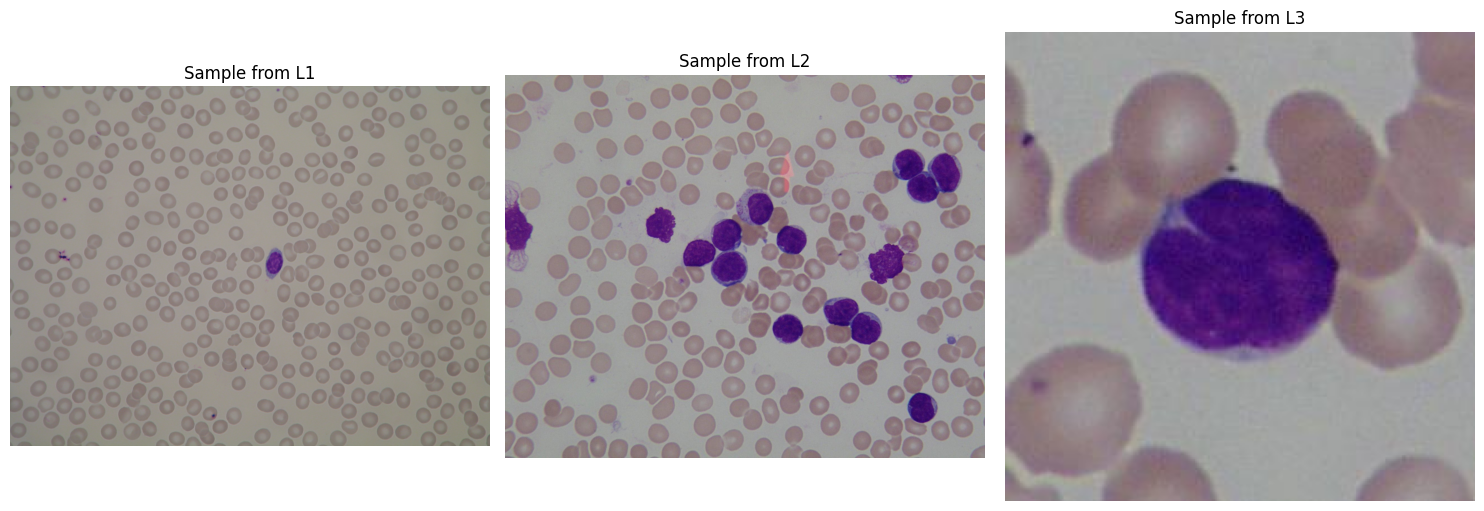

In [5]:
# CODE CELL
def load_images_from_folder(folder):
    """Load all images from a folder into a list."""
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Convert to RGB (OpenCV loads as BGR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            filenames.append(filename)
    return images, filenames

# Load images from each folder
print("Loading images...")
l1_images, l1_filenames = load_images_from_folder('/content/leukemia_detection/data/L1')
l2_images, l2_filenames = load_images_from_folder('/content/leukemia_detection/data/L2')
l3_images, l3_filenames = load_images_from_folder('/content/leukemia_detection/data/L3')

print(f"L1 images: {len(l1_images)}")
print(f"L2 images: {len(l2_images)}")
print(f"L3 images: {len(l3_images)}")

# CODE CELL
# Visualize sample images from each folder
plt.figure(figsize=(15, 5))
for i, (folder_images, folder_name) in enumerate(zip([l1_images, l2_images, l3_images], ['L1', 'L2', 'L3'])):
    if len(folder_images) > 0:
        plt.subplot(1, 3, i+1)
        plt.imshow(folder_images[0])
        plt.title(f"Sample from {folder_name}")
        plt.axis('off')
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

# MARKDOWN CELL
### Image Properties Analysis


--- L1 Image Properties ---
Number of images: 50
Image dimensions (height, width): (1944, 2592) (first image)
Unique image sizes: 1
Number of channels: 3
Average pixel intensity: 133.65
Average standard deviation: 15.71

--- L2 Image Properties ---
Number of images: 50
Image dimensions (height, width): (1368, 1712) (first image)
Unique image sizes: 1
Number of channels: 3
Average pixel intensity: 140.55
Average standard deviation: 23.03

--- L3 Image Properties ---
Number of images: 50
Image dimensions (height, width): (257, 257) (first image)
Unique image sizes: 2
Number of channels: 3
Average pixel intensity: 134.91
Average standard deviation: 35.69


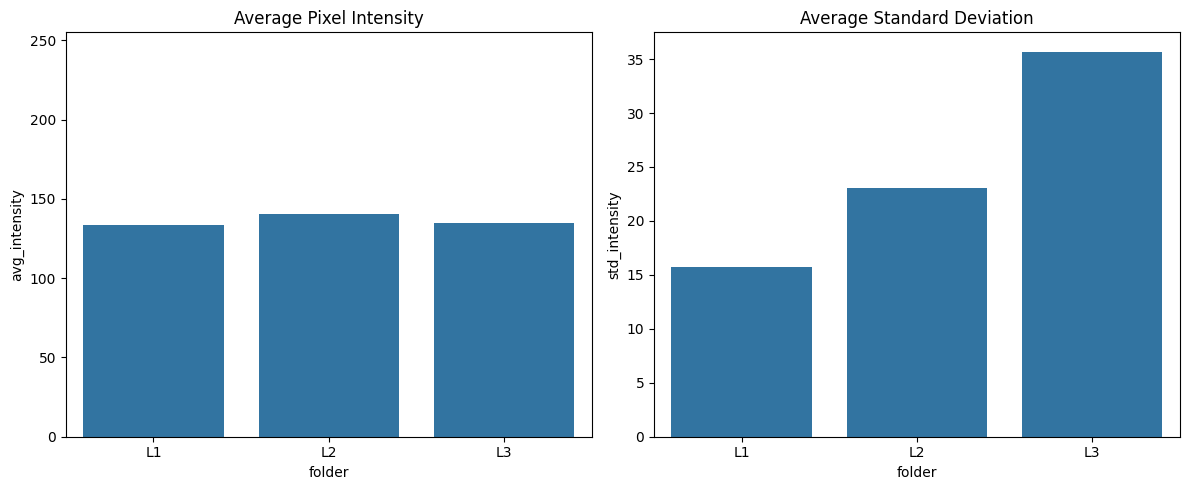

In [6]:
# CODE CELL
# Analyze image properties (size, channels, etc.)
def analyze_image_properties(image_list, folder_name):
    """Analyze and display properties of images in a folder."""
    sizes = []
    channels = []
    avg_intensity = []
    std_intensity = []

    for img in image_list:
        h, w, c = img.shape
        sizes.append((h, w))
        channels.append(c)
        avg_intensity.append(np.mean(img))
        std_intensity.append(np.std(img))

    print(f"\n--- {folder_name} Image Properties ---")
    print(f"Number of images: {len(image_list)}")
    print(f"Image dimensions (height, width): {sizes[0]} (first image)")
    print(f"Unique image sizes: {len(set(sizes))}")
    print(f"Number of channels: {channels[0]}")
    print(f"Average pixel intensity: {np.mean(avg_intensity):.2f}")
    print(f"Average standard deviation: {np.mean(std_intensity):.2f}")

    return {
        'folder': folder_name,
        'num_images': len(image_list),
        'avg_intensity': np.mean(avg_intensity),
        'std_intensity': np.mean(std_intensity)
    }

# Analyze images from each folder
l1_stats = analyze_image_properties(l1_images, 'L1')
l2_stats = analyze_image_properties(l2_images, 'L2')
l3_stats = analyze_image_properties(l3_images, 'L3')

# Create a DataFrame for visualization
stats_df = pd.DataFrame([l1_stats, l2_stats, l3_stats])

# CODE CELL
# Visualize image statistics
plt.figure(figsize=(12, 5))

# Average intensity
plt.subplot(1, 2, 1)
sns.barplot(x='folder', y='avg_intensity', data=stats_df)
plt.title('Average Pixel Intensity')
plt.ylim(0, 255)

# Standard deviation
plt.subplot(1, 2, 2)
sns.barplot(x='folder', y='std_intensity', data=stats_df)
plt.title('Average Standard Deviation')

plt.tight_layout()
plt.savefig('image_statistics.png')
plt.show()



# MARKDOWN CELL
### Color Distribution Analysis


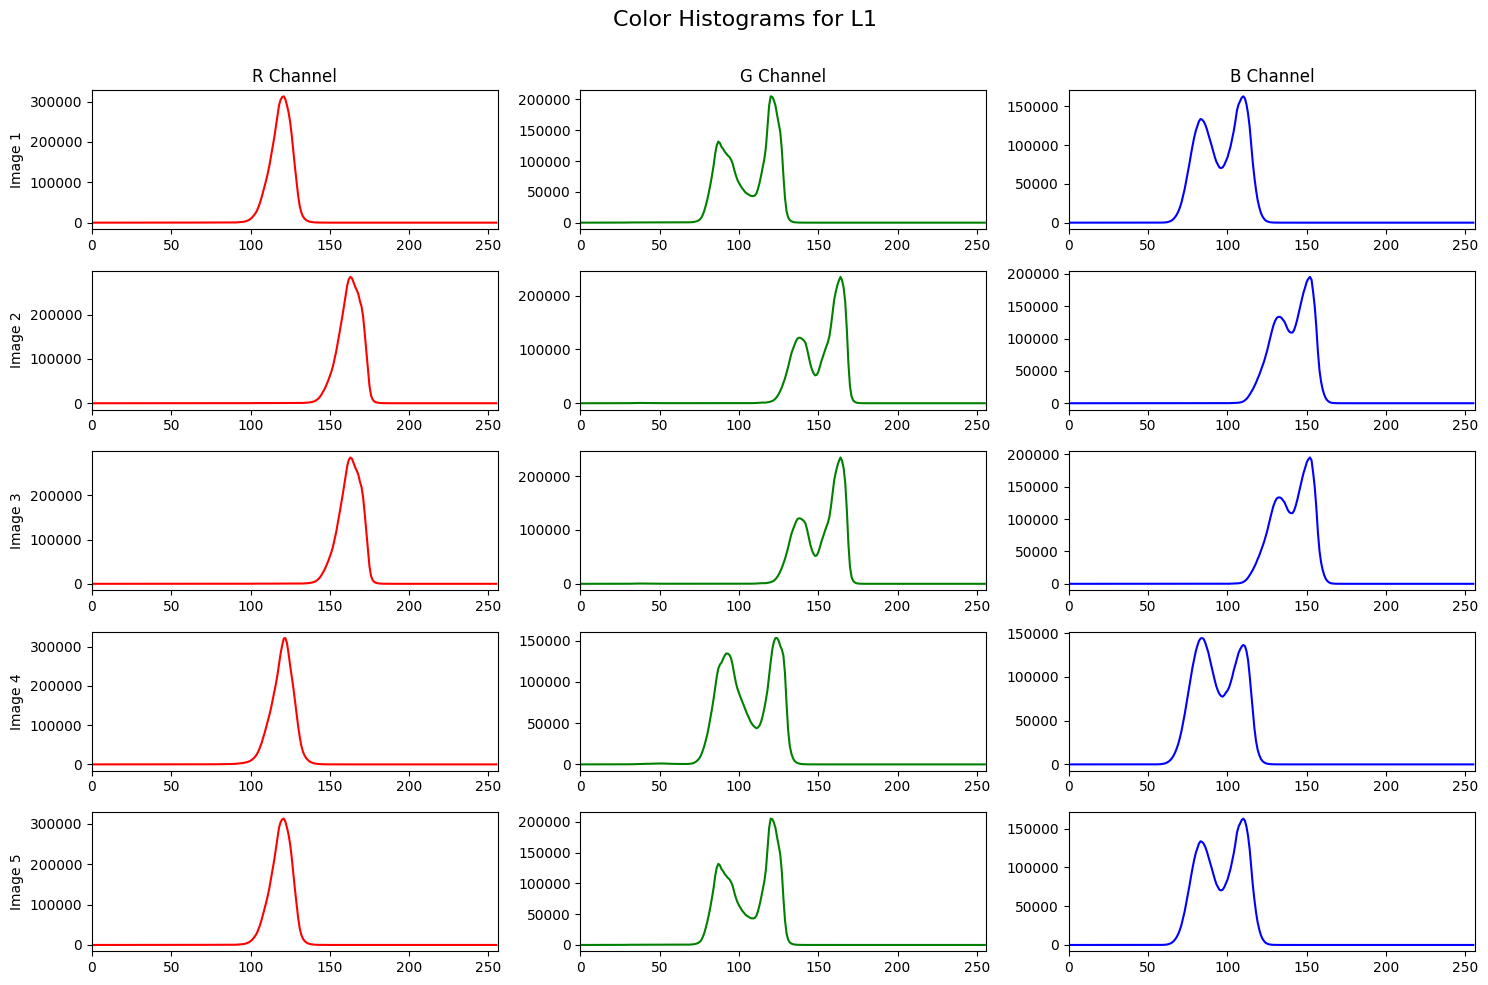

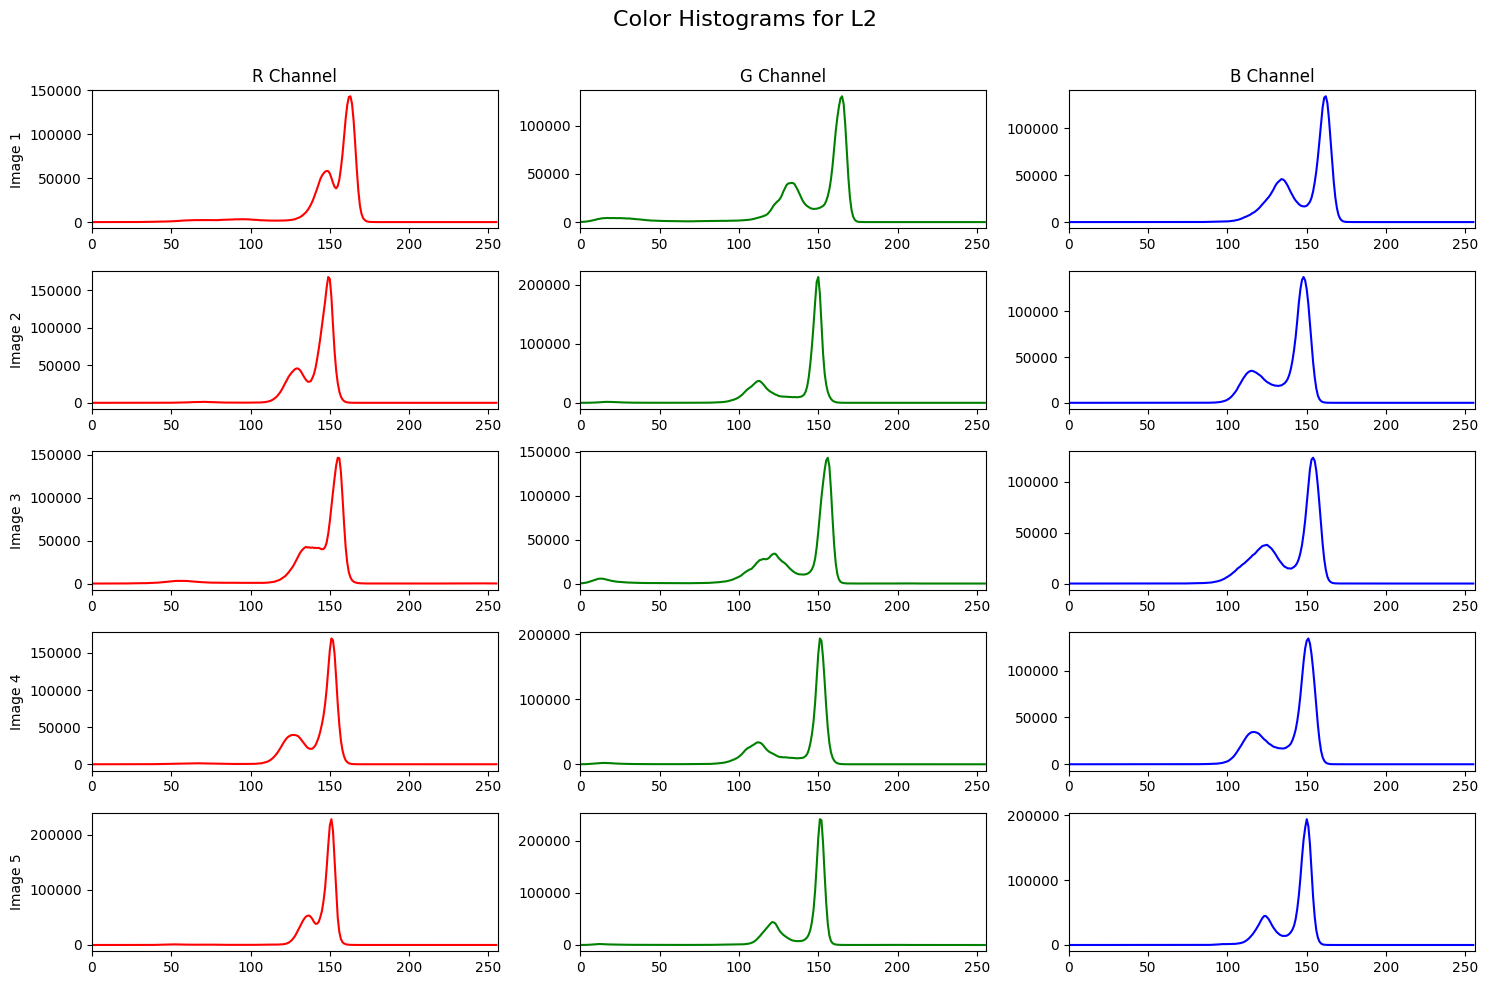

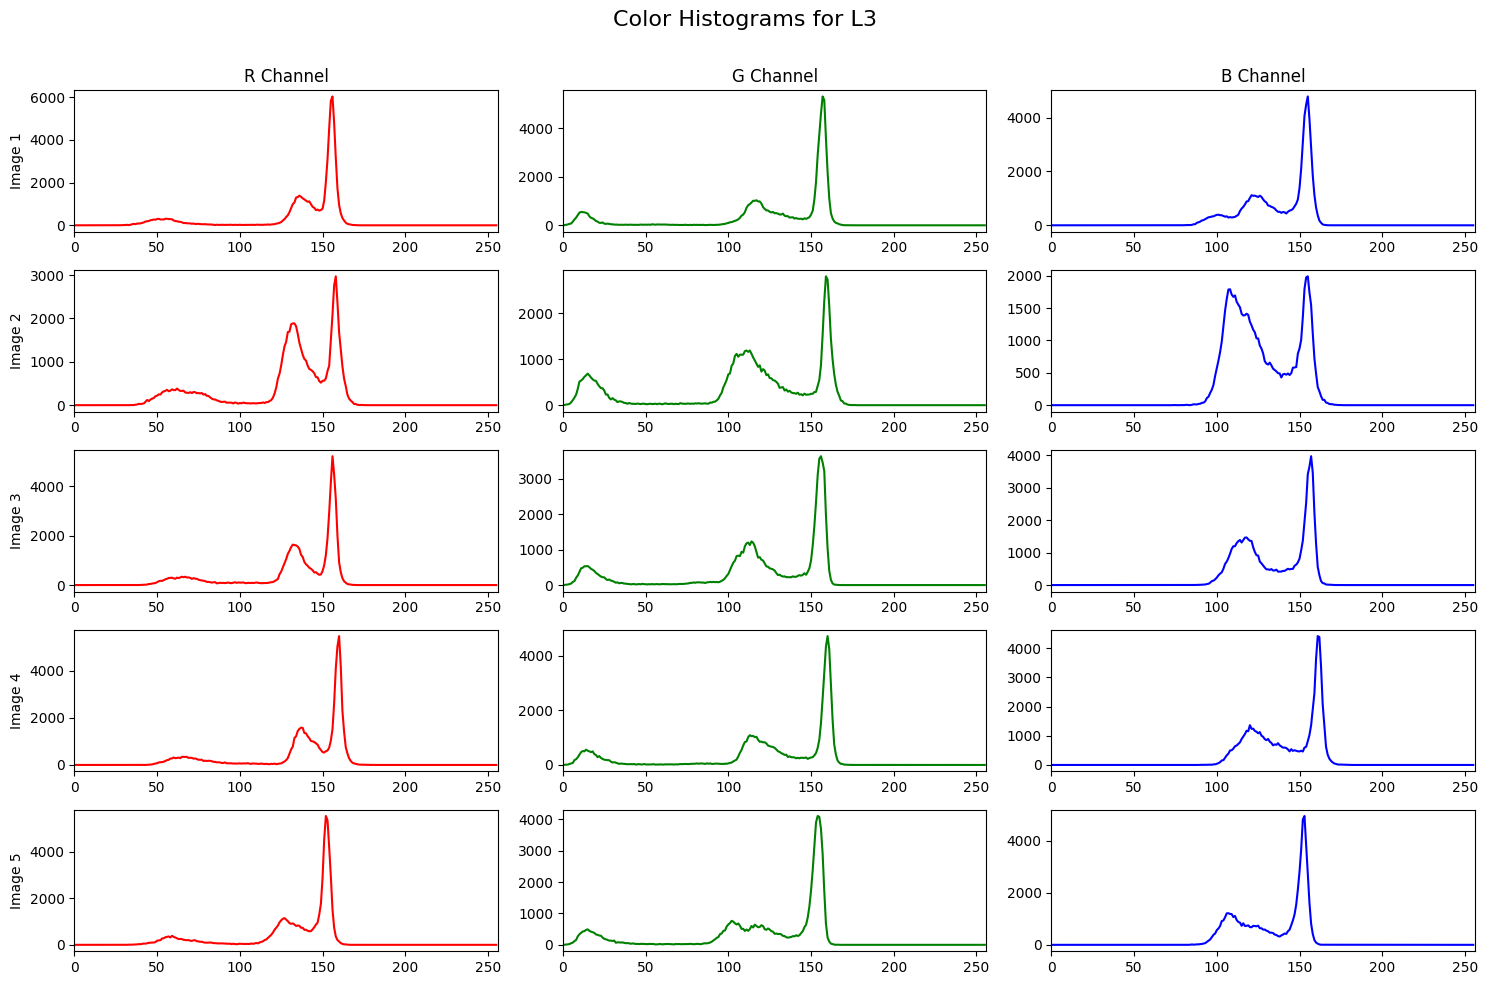

In [7]:
# CODE CELL
# Analyze color distribution in images
def plot_color_histograms(images, folder_name):
    """Plot color histograms for a sample of images from a folder."""
    # Sample up to 5 images
    sample_images = random.sample(images, min(5, len(images)))

    plt.figure(figsize=(15, 10))
    plt.suptitle(f'Color Histograms for {folder_name}', fontsize=16)

    for i, img in enumerate(sample_images):
        colors = ('r', 'g', 'b')
        for j, color in enumerate(colors):
            plt.subplot(len(sample_images), 3, i*3 + j + 1)
            histogram = cv2.calcHist([img], [j], None, [256], [0, 256])
            plt.plot(histogram, color=color)
            plt.xlim([0, 256])
            if i == 0:
                plt.title(f'{color.upper()} Channel')
            if j == 0:
                plt.ylabel(f'Image {i+1}')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'{folder_name}_color_histograms.png')
    plt.show()

# Plot color histograms for each folder
for images, folder_name in zip([l1_images, l2_images, l3_images], ['L1', 'L2', 'L3']):
    if len(images) > 0:
        plot_color_histograms(images, folder_name)


# MARKDOWN CELL
### Structural Similarity Index (SSIM) Analysis



--- Structural Similarity Index (SSIM) Analysis ---
SSIM between L1 and L2: 0.1102
SSIM between L1 and L3: 0.1721
SSIM between L2 and L3: 0.1980

Internal similarity:
SSIM within L1: 0.1161
SSIM within L2: 0.1215
SSIM within L3: 0.4568


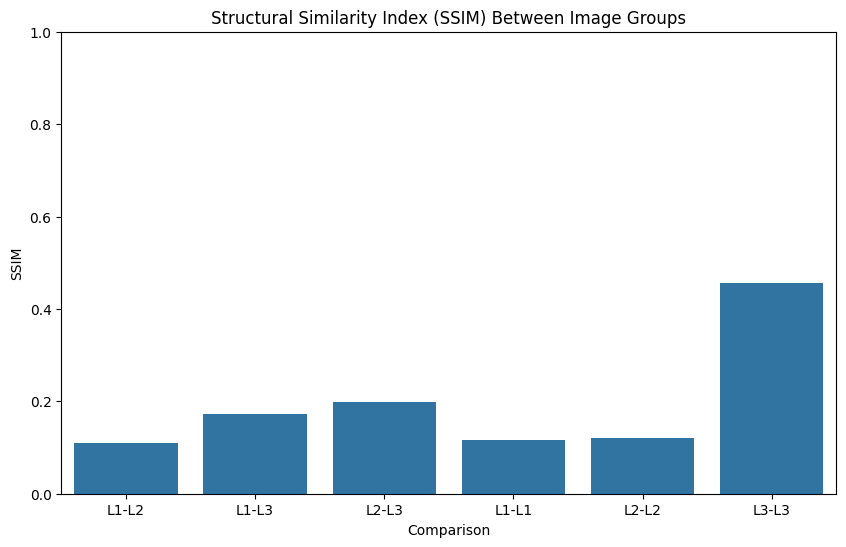

In [8]:
# CODE CELL
def calculate_avg_ssim(images_list1, images_list2, n_samples=5):
    """Calculate average SSIM between two sets of images."""
    if len(images_list1) == 0 or len(images_list2) == 0:
        return 0

    # Resize images to a common size for comparison
    size = (256, 256)

    # Sample images from both lists
    samples1 = random.sample(images_list1, min(n_samples, len(images_list1)))
    samples2 = random.sample(images_list2, min(n_samples, len(images_list2)))

    ssim_values = []

    for img1 in samples1:
        img1_resized = cv2.resize(img1, size)
        img1_gray = cv2.cvtColor(img1_resized, cv2.COLOR_RGB2GRAY)

        for img2 in samples2:
            img2_resized = cv2.resize(img2, size)
            img2_gray = cv2.cvtColor(img2_resized, cv2.COLOR_RGB2GRAY)

            # Calculate SSIM
            ssim_value = ssim(img1_gray, img2_gray, data_range=img2_gray.max() - img2_gray.min())
            ssim_values.append(ssim_value)

    return np.mean(ssim_values)

# Calculate SSIM between image groups
ssim_l1_l2 = calculate_avg_ssim(l1_images, l2_images)
ssim_l1_l3 = calculate_avg_ssim(l1_images, l3_images)
ssim_l2_l3 = calculate_avg_ssim(l2_images, l3_images)

# Calculate SSIM within groups (internal similarity)
ssim_l1_l1 = calculate_avg_ssim(l1_images, l1_images)
ssim_l2_l2 = calculate_avg_ssim(l2_images, l2_images)
ssim_l3_l3 = calculate_avg_ssim(l3_images, l3_images)

print("\n--- Structural Similarity Index (SSIM) Analysis ---")
print(f"SSIM between L1 and L2: {ssim_l1_l2:.4f}")
print(f"SSIM between L1 and L3: {ssim_l1_l3:.4f}")
print(f"SSIM between L2 and L3: {ssim_l2_l3:.4f}")
print("\nInternal similarity:")
print(f"SSIM within L1: {ssim_l1_l1:.4f}")
print(f"SSIM within L2: {ssim_l2_l2:.4f}")
print(f"SSIM within L3: {ssim_l3_l3:.4f}")

# CODE CELL
# Visualize SSIM results
ssim_data = [
    ['L1-L2', ssim_l1_l2],
    ['L1-L3', ssim_l1_l3],
    ['L2-L3', ssim_l2_l3],
    ['L1-L1', ssim_l1_l1],
    ['L2-L2', ssim_l2_l2],
    ['L3-L3', ssim_l3_l3]
]

ssim_df = pd.DataFrame(ssim_data, columns=['Comparison', 'SSIM'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Comparison', y='SSIM', data=ssim_df)
plt.title('Structural Similarity Index (SSIM) Between Image Groups')
plt.ylim(0, 1)
plt.savefig('ssim_comparison.png')
plt.show()



# MARKDOWN CELL
## Part 2: Synthetic Numerical Dataset Creation and Analysis

### Create Synthetic Dataset

In [9]:
# CODE CELL
# Create a synthetic numerical dataset for leukemia detection
def create_synthetic_dataset(n_samples=7257):
    """Create a synthetic dataset for leukemia detection with realistic features."""

    # Define features and their distributions
    np.random.seed(42)

    # Generate data
    data = {
        'patient_id': range(1, n_samples + 1),
        'age': np.random.normal(45, 15, n_samples).clip(2, 90).astype(int),
        'wbc_count': np.random.normal(20000, 15000, n_samples).clip(1000, 100000),
        'rbc_count': np.random.normal(3.5, 1.0, n_samples).clip(1.0, 7.0),
        'hemoglobin': np.random.normal(10.5, 2.5, n_samples).clip(4.0, 17.0),
        'platelets': np.random.normal(120000, 80000, n_samples).clip(10000, 450000),
        'blast_cells_percentage': np.random.normal(15, 20, n_samples).clip(0, 100),
        'lymphocytes_percentage': np.random.normal(25, 15, n_samples).clip(0, 90),
        'neutrophils_percentage': np.random.normal(35, 20, n_samples).clip(0, 85)
    }

    # Generate a target variable based on features
    # High blast cell percentage and low RBC/hemoglobin are indicators of leukemia
    leukemia_score = (
        data['blast_cells_percentage'] / 100 * 3 -
        data['rbc_count'] / 7.0 * 1.5 -
        data['hemoglobin'] / 17.0 * 1.5 +
        data['wbc_count'] / 100000 * 2
    )

    # Normalize score to 0-1 range
    leukemia_score = (leukemia_score - leukemia_score.min()) / (leukemia_score.max() - leukemia_score.min())

    # Generate target based on score
    # 0: Normal, 1: Suspected, 2: AML (Acute Myeloid Leukemia), 3: Other blood disorders
    thresholds = [0.3, 0.6, 0.85]
    data['diagnosis'] = np.digitize(leukemia_score, thresholds)

    # Convert diagnosis to labels
    diagnosis_map = {0: 'Normal', 1: 'Suspected', 2: 'AML', 3: 'Other'}
    data['diagnosis_label'] = [diagnosis_map[d] for d in data['diagnosis']]

    # Create DataFrame
    df = pd.DataFrame(data)

    # Add some random noise and missing values to make dataset more realistic
    for col in ['wbc_count', 'rbc_count', 'hemoglobin', 'platelets']:
        mask = np.random.random(n_samples) < 0.01  # 1% missing values
        df.loc[mask, col] = np.nan

    return df

# Create the dataset
numerical_df = create_synthetic_dataset(7257)

# Save to CSV
numerical_df.to_csv('leukemia_numerical_data.csv', index=False)
print("Synthetic numerical dataset created and saved.")
print(f"Dataset shape: {numerical_df.shape}")
numerical_df.head()


Synthetic numerical dataset created and saved.
Dataset shape: (7257, 11)


,patient_id,age,wbc_count,rbc_count,hemoglobin,platelets,blast_cells_percentage,lymphocytes_percentage,neutrophils_percentage,diagnosis,diagnosis_label
0,1,52,29733.228889,3.336074,10.122007,10000.000000,24.915270,24.046132,27.822939,1,Suspected
1,2,42,11233.985351,3.902262,8.534256,50036.118068,2.783521,50.894769,26.706555,0,Normal
2,3,54,56785.548693,4.449257,10.563114,214702.158919,53.655917,0.000000,56.031582,2,AML
3,4,67,49754.504787,3.036216,14.887709,202898.250148,0.000000,7.571798,46.363405,1,Suspected
4,5,41,20178.206518,4.835105,9.242938,166236.142588,38.241415,14.980421,23.720223,1,Suspected


# MARKDOWN CELL
### Exploratory Data Analysis of Numerical Dataset



--- Numerical Dataset Statistics ---
        patient_id          age     wbc_count    rbc_count   hemoglobin  \
count  7257.000000  7257.000000   7177.000000  7185.000000  7185.000000   
mean   3629.000000    44.404713  20802.515937     3.513498    10.456985   
std    2095.059784    15.027861  13644.160683     0.996761     2.445923   
min       1.000000     2.000000   1000.000000     1.000000     4.000000   
25%    1815.000000    34.000000  10053.617393     2.833355     8.727415   
50%    3629.000000    44.000000  20027.052595     3.516621    10.479809   
75%    5443.000000    55.000000  30106.532515     4.198266    12.128620   
max    7257.000000    90.000000  71433.657170     7.000000    17.000000   

           platelets  blast_cells_percentage  lymphocytes_percentage  \
count    7176.000000             7257.000000             7257.000000   
mean   122322.753879               17.810695               25.285281   
std     75196.135312               16.209870               14.248857  

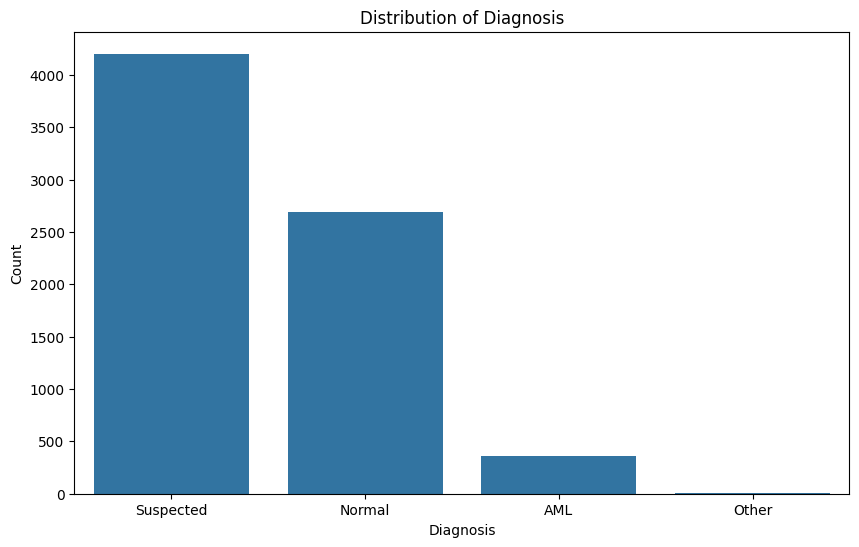

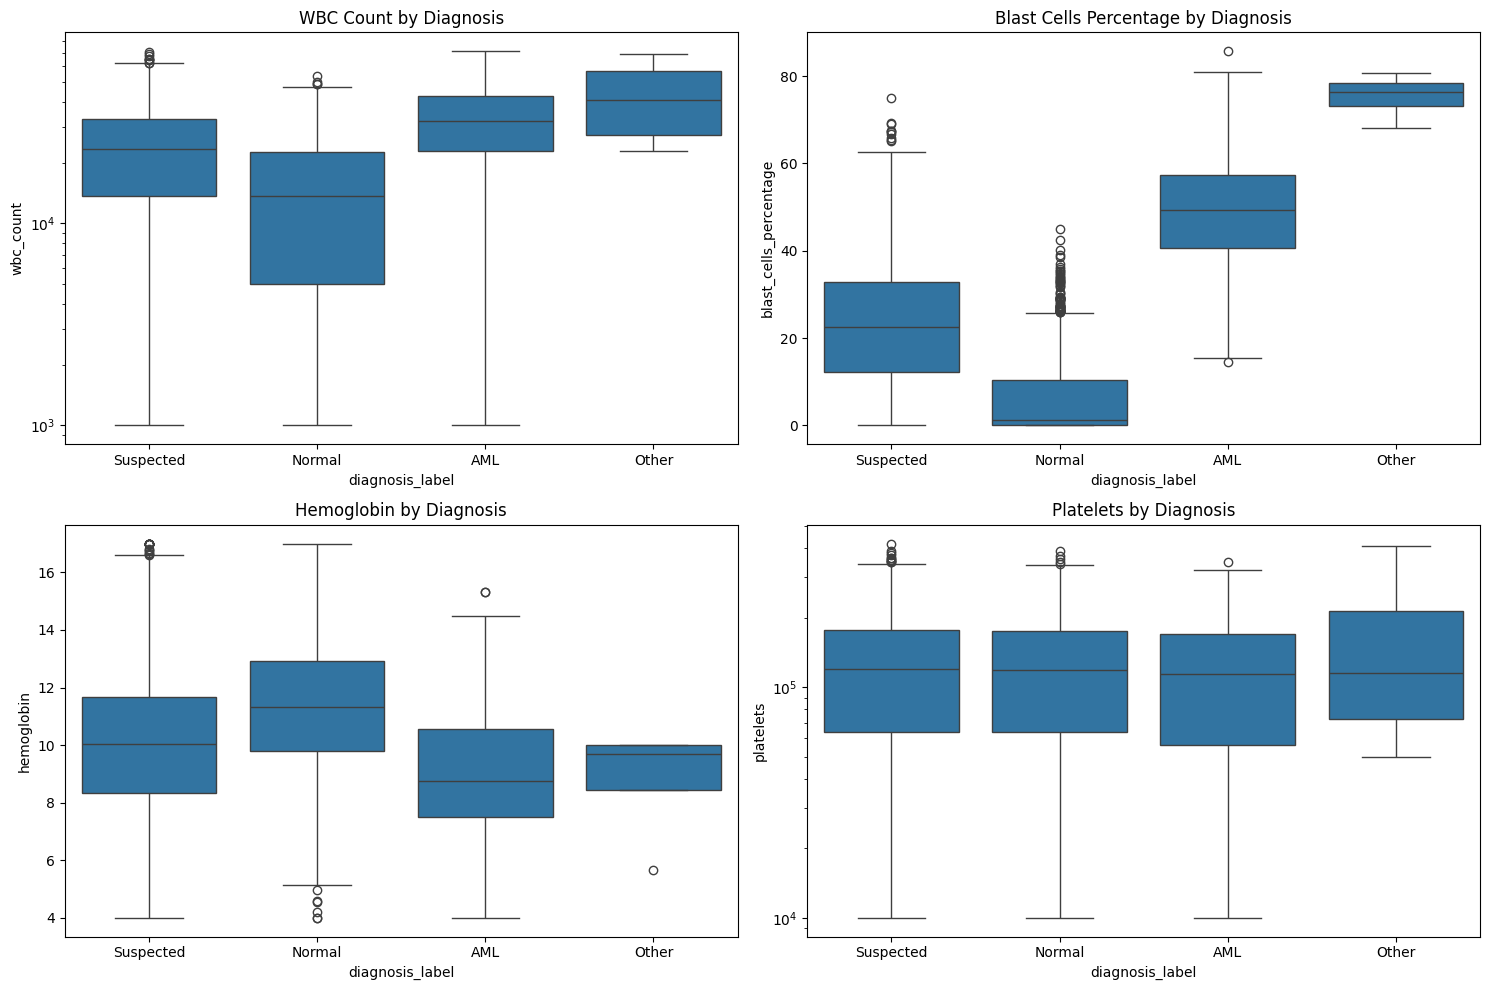

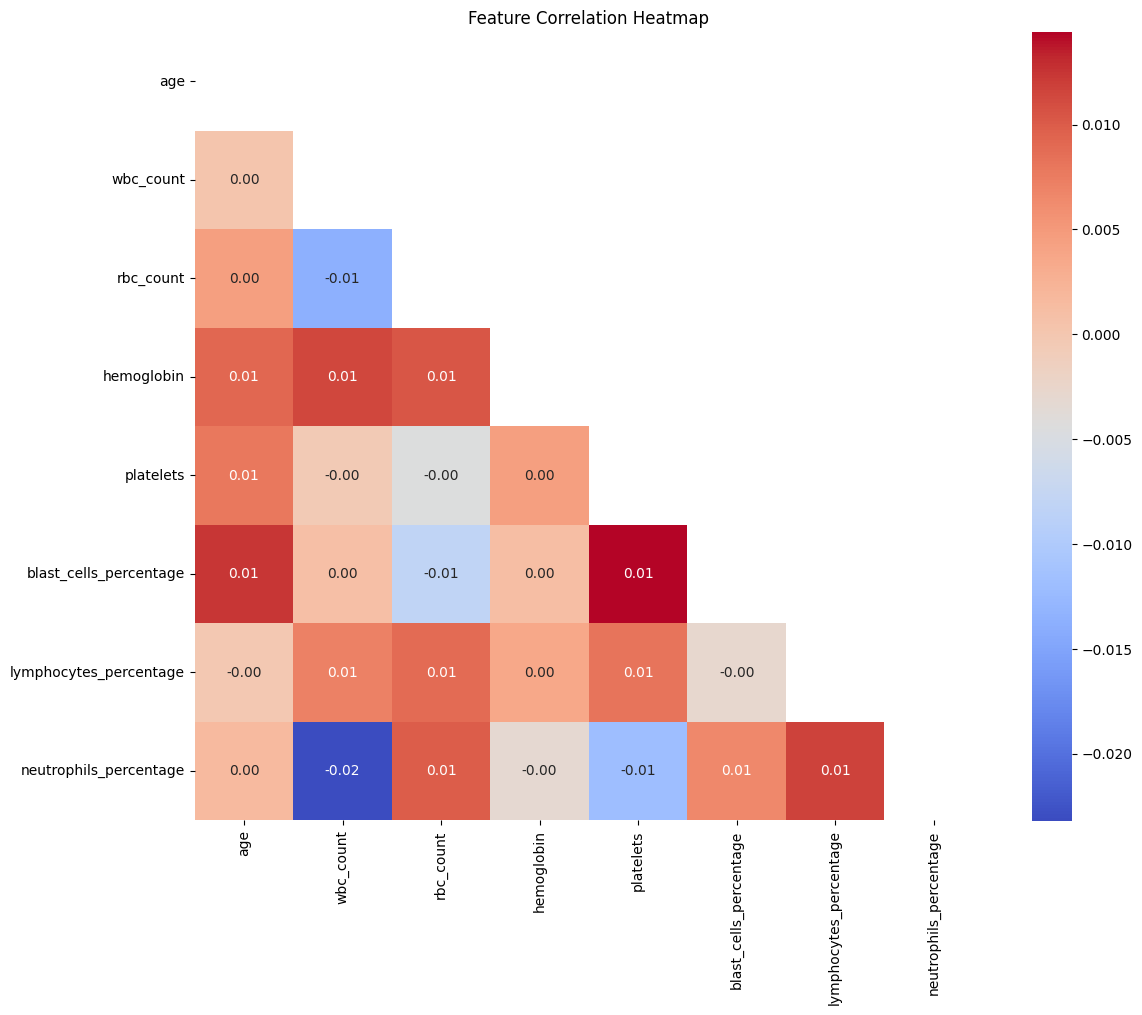

<Figure size 1500x1500 with 0 Axes>

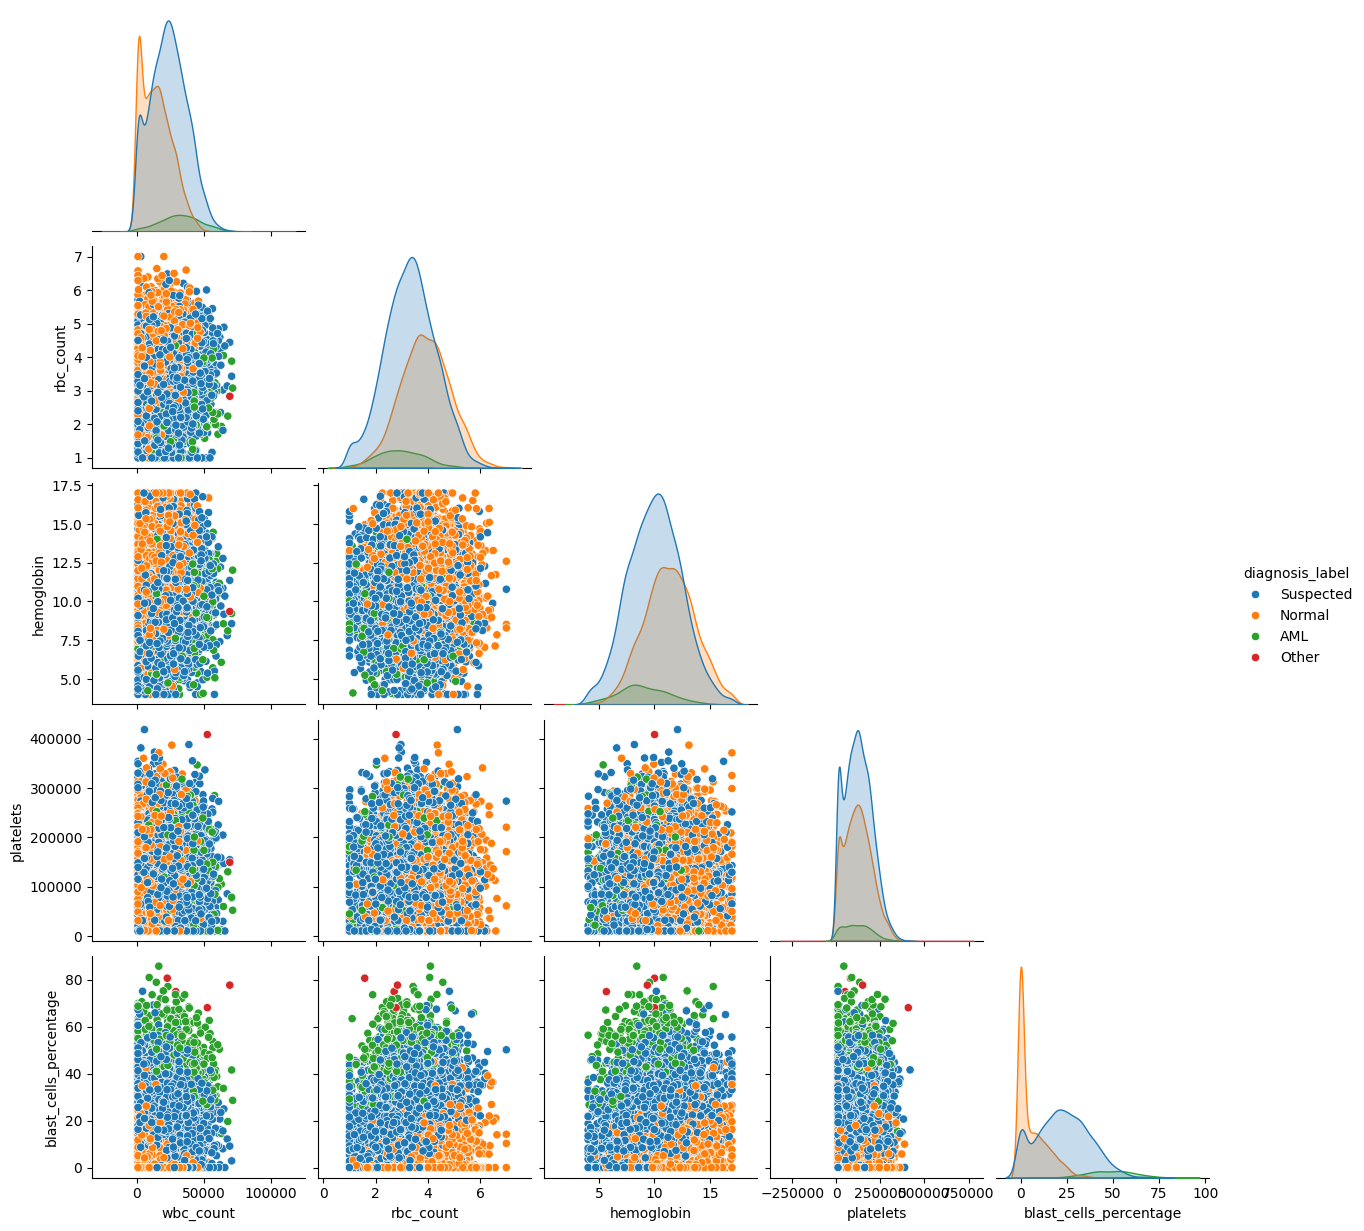

In [10]:
# CODE CELL
# Basic statistics
print("\n--- Numerical Dataset Statistics ---")
print(numerical_df.describe())

# Check for missing values
print("\n--- Missing Values ---")
print(numerical_df.isnull().sum())

# Distribution of diagnosis
print("\n--- Diagnosis Distribution ---")
diagnosis_counts = numerical_df['diagnosis_label'].value_counts()
print(diagnosis_counts)

# CODE CELL
# Visualize diagnosis distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='diagnosis_label', data=numerical_df)
plt.title('Distribution of Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig('diagnosis_distribution.png')
plt.show()

# CODE CELL
# Visualize feature distributions by diagnosis
plt.figure(figsize=(15, 10))

# WBC count
plt.subplot(2, 2, 1)
sns.boxplot(x='diagnosis_label', y='wbc_count', data=numerical_df)
plt.title('WBC Count by Diagnosis')
plt.yscale('log')

# Blast cells percentage
plt.subplot(2, 2, 2)
sns.boxplot(x='diagnosis_label', y='blast_cells_percentage', data=numerical_df)
plt.title('Blast Cells Percentage by Diagnosis')

# Hemoglobin
plt.subplot(2, 2, 3)
sns.boxplot(x='diagnosis_label', y='hemoglobin', data=numerical_df)
plt.title('Hemoglobin by Diagnosis')

# Platelets
plt.subplot(2, 2, 4)
sns.boxplot(x='diagnosis_label', y='platelets', data=numerical_df)
plt.title('Platelets by Diagnosis')
plt.yscale('log')

plt.tight_layout()
plt.savefig('features_by_diagnosis.png')
plt.show()

# CODE CELL
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = numerical_df.select_dtypes(include=[np.number]).drop(['patient_id', 'diagnosis'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

# CODE CELL
# Feature relationships
plt.figure(figsize=(15, 15))
features = ['wbc_count', 'rbc_count', 'hemoglobin', 'platelets', 'blast_cells_percentage']
sns.pairplot(numerical_df[features + ['diagnosis_label']], hue='diagnosis_label', corner=True)
plt.savefig('feature_relationships.png')
plt.show()


# MARKDOWN CELL
## Part 3: Model Training and Hypothesis Testing

### CNN-based Model (Baseline)

Found 120 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,203 (72.61 MB)

 Trainable params: 19,035,203 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3268 - loss: 2.1777 - precision: 0.2208 - recall: 0.1302 - val_accuracy: 0.3333 - val_loss: 1.4178 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.3750 - loss: 1.4857 - precision: 0.3636 - recall: 0.3333 - val_accuracy: 0.3333 - val_loss: 1.1941 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3477 - loss: 1.1800 - precision: 0.3980 - recall: 0.2198 - val_accuracy: 1.0000 - val_loss: 0.8389 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.9688 - loss: 0.8452 - precision: 1.0000 - recall: 0.2188 - val_accuracy: 0.5333 - val_loss: 0.7825 - val_precision: 1.0000 - val_recall: 0.3333
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7370 - loss: 0.7307 - precision: 0.9529 - recall: 0.3803 - val_accuracy: 0.5333 - val_loss: 0.9137 - val_precis

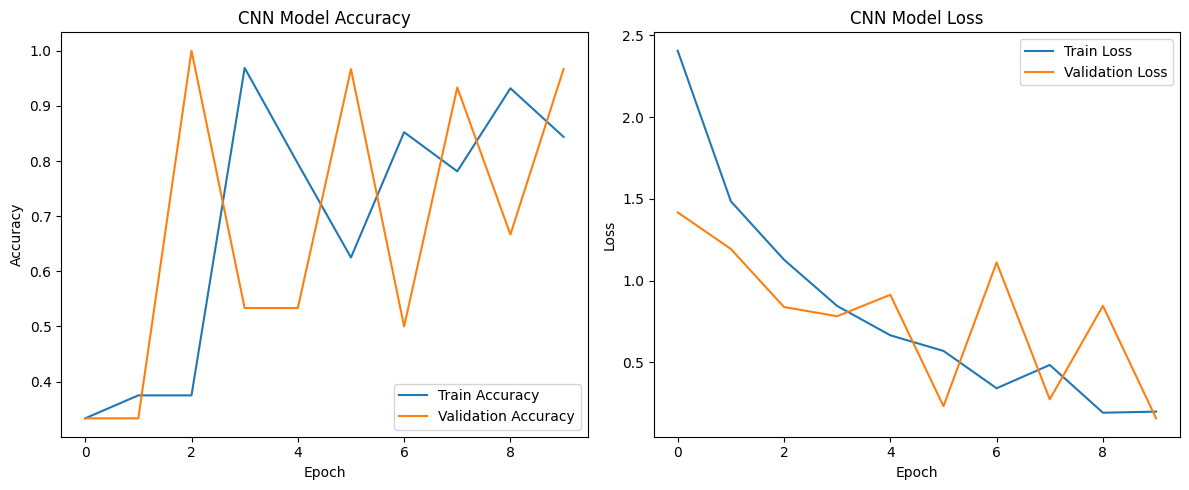

In [11]:
# CODE CELL
# Prepare image data for modeling
def prepare_image_data(base_path, img_size=(150, 150), batch_size=32):
    """Prepare image data for model training."""

    # Data augmentation for training set
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescaling for validation set
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    # Load training data
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Load validation data
    validation_generator = val_datagen.flow_from_directory(
        base_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator

# Prepare the data
img_size = (150, 150)
batch_size = 32
train_generator, validation_generator = prepare_image_data('/content/leukemia_detection/data', img_size, batch_size)

# CODE CELL
# Build a basic CNN model
def build_cnn_model(input_shape, num_classes):
    """Build a basic CNN model."""
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# Build the CNN model
input_shape = img_size + (3,)  # (150, 150, 3)
num_classes = len(train_generator.class_indices)
cnn_model = build_cnn_model(input_shape, num_classes)

# Print model summary
cnn_model.summary()

# CODE CELL
# Train the CNN model
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    verbose=1
)

# Evaluate the CNN model
cnn_evaluation = cnn_model.evaluate(validation_generator)
print(f"\nCNN Model Evaluation:")
print(f"Loss: {cnn_evaluation[0]:.4f}")
print(f"Accuracy: {cnn_evaluation[1]:.4f}")
print(f"Precision: {cnn_evaluation[2]:.4f}")
print(f"Recall: {cnn_evaluation[3]:.4f}")

# Calculate F1 score
cnn_f1 = 2 * (cnn_evaluation[2] * cnn_evaluation[3]) / (cnn_evaluation[2] + cnn_evaluation[3])
print(f"F1 Score: {cnn_f1:.4f}")

# CODE CELL
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('cnn_training_history.png')
plt.show()


# MARKDOWN CELL
### Transfer Learning Model


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,867 (64.14 MB)

 Trainable params: 2,098,179 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step - accuracy: 0.3883 - loss: 1.4973 - precision_1: 0.4271 - recall_1: 0.3467 - val_accuracy: 0.9333 - val_loss: 0.2595 - val_precision_1: 0.9333 - val_recall_1: 0.9333
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step - accuracy: 0.6562 - loss: 0.7227 - precision_1: 0.6774 - recall_1: 0.6562 - val_accuracy: 0.9667 - val_loss: 0.0971 - val_precision_1: 0.9667 - val_recall_1: 0.9667
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9102 - loss: 0.2787 - precision_1: 0.9102 - recall_1: 0.9102 - val_accuracy: 1.0000 - val_loss: 0.0702 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - accuracy: 0.9375 - loss: 0.2616 - precision_1: 0.9375 - recall_1: 0.9375 - val_accuracy: 1.0000 - val_loss: 0.0335 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9605 - loss: 0.1131 - precision_1: 0.9605 - recall_1: 0.9605 - val_accuracy: 1.0

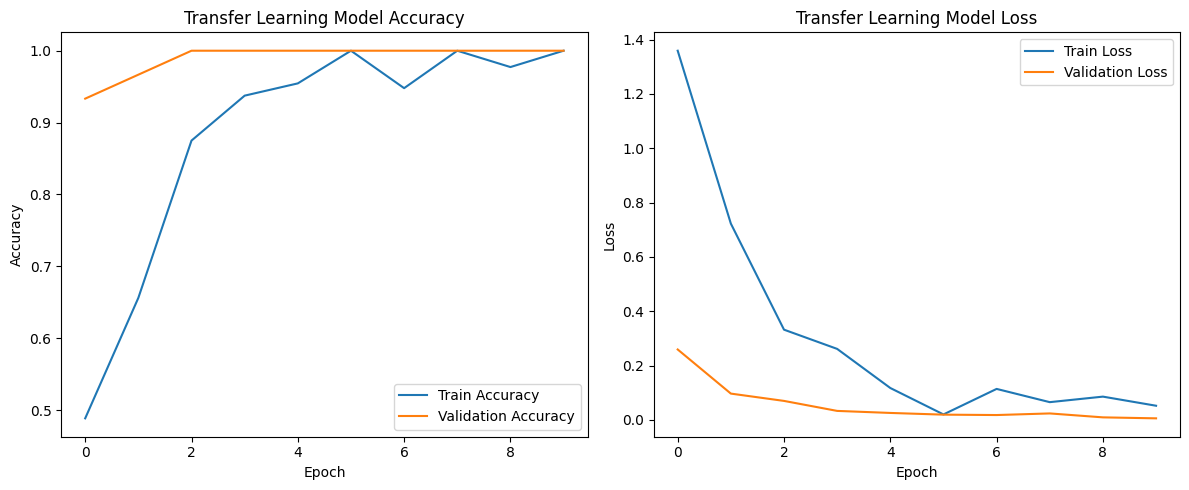

In [12]:
# CODE CELL
# Build a transfer learning model using VGG16
def build_transfer_learning_model(input_shape, num_classes):
    """Build a transfer learning model using pre-trained VGG16."""
    # Load pre-trained VGG16 model
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# Build the transfer learning model
tl_model = build_transfer_learning_model(input_shape, num_classes)

# Print model summary
tl_model.summary()

# CODE CELL
# Train the transfer learning model
tl_history = tl_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    verbose=1
)

# Evaluate the transfer learning model
tl_evaluation = tl_model.evaluate(validation_generator)
print(f"\nTransfer Learning Model Evaluation:")
print(f"Loss: {tl_evaluation[0]:.4f}")
print(f"Accuracy: {tl_evaluation[1]:.4f}")
print(f"Precision: {tl_evaluation[2]:.4f}")
print(f"Recall: {tl_evaluation[3]:.4f}")

# Calculate F1 score
tl_f1 = 2 * (tl_evaluation[2] * tl_evaluation[3]) / (tl_evaluation[2] + tl_evaluation[3])
print(f"F1 Score: {tl_f1:.4f}")

# CODE CELL
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(tl_history.history['accuracy'], label='Train Accuracy')
plt.plot(tl_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(tl_history.history['loss'], label='Train Loss')
plt.plot(tl_history.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('tl_training_history.png')
plt.show()


# MARKDOWN CELL
## Hypothesis Testing
### Statistical Test of Model Comparison



In [13]:


# CODE CELL
# Compare F1 scores of the two models
print("\n--- Model Comparison ---")
print(f"CNN Model F1 Score: {cnn_f1:.4f}")
print(f"Transfer Learning Model F1 Score: {tl_f1:.4f}")
print(f"Difference in F1 Score: {tl_f1 - cnn_f1:.4f}")

# Perform statistical test (bootstrap sampling)
def bootstrap_f1_scores(model, data_generator, n_samples=1000):
    """Generate bootstrap samples of F1 scores."""
    f1_scores = []

    # Reset generator to the beginning
    data_generator.reset()

    # Get predictions for all validation samples
    y_true = []
    y_pred = []

    for i in range(len(data_generator)):
        x_batch, y_batch = data_generator[i]
        pred_batch = model.predict(x_batch)

        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(pred_batch, axis=1))

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Bootstrapping
    n_samples_total = len(y_true)
    for _ in range(n_samples):
        # Sample with replacement
        indices = np.random.choice(n_samples_total, n_samples_total, replace=True)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]

        # Calculate F1 score for this sample
        f1 = f1_score(y_true_sample, y_pred_sample, average='weighted')
        f1_scores.append(f1)

    return np.array(f1_scores)

# Generate bootstrap samples
cnn_f1_samples = bootstrap_f1_scores(cnn_model, validation_generator)
tl_f1_samples = bootstrap_f1_scores(tl_model, validation_generator)

# Calculate p-value
diff_samples = tl_f1_samples - cnn_f1_samples
p_value = np.mean(diff_samples <= 0)

print(f"Bootstrap p-value: {p_value:.4f}")

# Set significance level
alpha = 0.05
print(f"Significance level: {alpha}")

# Test the hypothesis
if p_value < alpha:
    print("\nResult: Reject the null hypothesis.")
    print("The transfer learning-based model performs significantly better than the CNN-based model.")
else:
    print("\nResult: Fail to reject the null hypothesis.")
    print("There is not enough evidence to conclude that the transfer learning-based model performs better.")


--- Model Comparison ---
CNN Model F1 Score: 0.9667
Transfer Learning Model F1 Score: 1.0000
Difference in F1 Score: 0.0333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Bootstrap p-value: 0.3580
Significance level: 0.05

Result: Fail to reject the null hypothesis.
There is not enough evidence to conclude that the transfer learning-based model performs better.
